#### library

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys
from datetime import datetime, timedelta
from geopy.distance import great_circle

from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
import optuna
import catboost as cb

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

utils_directory = os.path.abspath('..')
sys.path.append(utils_directory)

import preprocessing

from utils.constant_utils import Directory
from utils import common_utils
from models.SpatialWeightMatrix import SpatialWeightMatrix
from models.XGBoostWithSpatialWeight import XGBoostWithSpatialWeight


import model
from inference import *

features_directory = os.path.abspath('../features')
sys.path.append(features_directory)

from clustering_features import *
from count_features import *
from distance_features import *
from other_features import *
from deposit_features import *

/data/ephemeral/home/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### data load

In [2]:
print("Start the main.py successfully!")

'''
name : 실험자 이름입니다.
title : result 폴더에 저장될 실험명을 지정합니다.
'''
name = 'eun'
title = 'cluster,timefeature,categorical,drop,gangnam,xgb1000'

print("total data load ...")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

Start the main.py successfully!
total data load ...


##### deposit features

In [3]:
def add_recent_rent_in_building(total_df: pd.DataFrame, type: str = 'valid'):
    total_df['contract_date'] = total_df['contract_year_month'] * 100 + total_df['contract_day']
    total_df['contract_date'] = pd.to_datetime(total_df['contract_date'], format='%Y%m%d')

    df_train, df_valid, df_test = common_utils.train_valid_test_split(total_df)

    if type == 'valid':
        df_train_new = df_train.copy()
        df_valid_new = df_valid.copy()

        df_train_sorted = df_train_new.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'contract_date'])

        df_train_sorted['recent_rent_in_building'] = df_train_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].shift(1)
        df_train_sorted['recent_rent_in_building'].fillna(df_train_sorted['deposit'], inplace=True)

        # 마지막 계약가 계산
        recent_rent_index = df_train_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].nth(-1).index
        recent_rent_df = df_train_sorted.loc[recent_rent_index]

        df_valid_new = df_valid_new.merge(recent_rent_df[['latitude', 'longitude', 'built_year', 'area_m2', 'recent_rent_in_building']], 
                                           on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')

        df_valid_new.fillna(recent_rent_df['recent_rent_in_building'].median(), inplace=True)

        return df_train_sorted.sort_index(), df_valid_new
        
    elif type == 'test':
        df_train_new = df_train.copy()
        df_valid_new = df_valid.copy()
        df_test_new = df_test.copy()

        df_total_new = pd.concat([df_train_new, df_valid_new], axis=0)
        df_total_new_sorted = df_total_new.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'contract_date'])

        df_total_new_sorted['recent_rent_in_building'] = df_total_new_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].shift(1)
        df_total_new_sorted['recent_rent_in_building'].fillna(df_total_new_sorted['deposit'], inplace=True)

        # 마지막 계약가 계산
        recent_rent_index = df_total_new_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].nth(-1).index
        recent_rent_df = df_total_new_sorted.loc[recent_rent_index]

        df_test_new = df_test_new.merge(recent_rent_df[['latitude', 'longitude', 'built_year', 'area_m2', 'recent_rent_in_building']], 
                                         on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')

        df_test_new.fillna(recent_rent_df['recent_rent_in_building'].median(), inplace=True)

        return df_total_new_sorted.sort_index(), df_test_new

In [4]:
# 동일한 지역(위도, 경도, 건축연도, 면적)의 과거 평균 전세가(중앙값으로 계산)
def add_avg_rent_in_past_year(total_df : pd.DataFrame, type : str = 'valid'):
    
    df_train, df_valid, df_test = common_utils.train_valid_test_split(total_df)


    if type == 'valid':
        df_train_new = df_train.copy()
        df_valid_new = df_valid.copy()
        
        
        df_train_new['contract_date'] = df_train_new['contract_year_month'] * 100 + df_train_new['contract_day']
        df_train_new['contract_date'] = pd.to_datetime(df_train_new['contract_date'], format='%Y%m%d')
        
        
        df_train_new['original_index'] = df_train_new.index
        df_train_new = df_train_new.sort_values(by=['latitude', 'longitude','area_m2','built_year','contract_date'], ascending=[True, True, True, True, True])
        
        df_train_new['avg_rent_in_past_year'] = df_train_new.groupby(['latitude', 'longitude','built_year', 'area_m2'])['deposit'].transform(lambda x : x.shift(1).expanding().median().round(1))
        df_train_new['avg_rent_in_past_year'].fillna(df_train_new['deposit'], inplace=True)

        df_train_new = df_train_new.sort_values(by='original_index').drop(columns='original_index')
        
        df_train_new_map = df_train_new.groupby(['latitude', 'longitude','built_year', 'area_m2'])['deposit'].median().reset_index()

        df_train_new_map.rename(columns={'deposit': 'deposit_median'}, inplace=True)
        df_valid_new = df_valid_new.merge(df_train_new_map, on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')
        
        df_valid_new['deposit_median'].fillna(df_train_new_map['deposit_median'].median(), inplace=True)


        return df_train_new, df_valid_new
        
        
    elif type == 'test':
        df_train_new = df_train.copy()
        df_valid_new = df_valid.copy()
        
        df_total_new = pd.concat([df_train_new, df_valid_new], axis=0)
        
        df_test_new = df_test.copy()
        
        
        df_total_new['contract_date'] = df_total_new['contract_year_month'] * 100 + df_total_new['contract_day']
        df_total_new['contract_date'] = pd.to_datetime(df_total_new['contract_date'], format='%Y%m%d')
        
        
        df_total_new['original_index'] = df_total_new.index
        df_total_new = df_total_new.sort_values(by=['latitude', 'longitude','area_m2','built_year','contract_date'], ascending=[True, True, True, True, True])
        
        df_total_new['avg_rent_in_past_year'] = df_total_new.groupby(['latitude', 'longitude','built_year', 'area_m2'])['deposit'].transform(lambda x : x.shift(1).expanding().median().round(1))
        df_total_new['avg_rent_in_past_year'].fillna(df_total_new['deposit'], inplace=True)

        df_total_new = df_total_new.sort_values(by='original_index').drop(columns='original_index')
        
        df_total_new_map = df_total_new.groupby(['latitude', 'longitude','built_year', 'area_m2'])['deposit'].median().reset_index()
        
        df_total_new_map.rename(columns={'deposit': 'deposit_median'}, inplace=True)
        df_test_new = df_test_new.merge(df_total_new_map, on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')
        
        df_test_new['deposit_median'].fillna(df_total_new_map['deposit_median'].median(), inplace=True)
    
    return df_total_new, df_test_new

In [5]:
# 연도별 전세가 상승률
def add_rent_growth_rate(total_df: pd.DataFrame, type: str = 'valid'):
    total_df['contract_year'] = total_df['contract_year_month'] // 100

    df_train, df_valid, df_test = common_utils.train_valid_test_split(total_df)

    if type == 'valid':
        df_train_new = df_train.copy()
        df_valid_new = df_valid.copy()

        # 연도별 전세가 중앙값 계산
        median_deposit = df_train_new.groupby(['latitude', 'longitude', 'contract_year'])['deposit'].median().reset_index()
        median_deposit['previous_year_deposit'] = median_deposit.groupby(['latitude', 'longitude'])['deposit'].shift(1)
        median_deposit['deposit_rate'] = ((median_deposit['deposit'] - median_deposit['previous_year_deposit']) / median_deposit['previous_year_deposit']).round(2)

        # 연도별 평균 상승률 계산
        mean_deposit_rate_per_year = median_deposit.groupby('contract_year')['deposit_rate'].transform('mean').round(2)
        median_deposit['deposit_rate'] = median_deposit['deposit_rate'].fillna(mean_deposit_rate_per_year)

        # 전체 평균 상승률 계산
        median_deposit['deposit_rate'] = median_deposit['deposit_rate'].fillna(median_deposit['deposit_rate'].mean().round(2))

        # train 데이터에 전세가 상승률 추가
        df_train_new = df_train_new.merge(median_deposit[['latitude', 'longitude', 'contract_year', 'deposit_rate']], 
                                          on=['latitude', 'longitude', 'contract_year'], how='left')

        # valid 데이터에 최신 전세가 상승률 추가
        recent_data = median_deposit.loc[median_deposit.groupby(['latitude', 'longitude'])['contract_year'].idxmax()]
        df_valid_new = df_valid_new.merge(recent_data[['latitude', 'longitude', 'deposit_rate']], 
                                          on=['latitude', 'longitude'], how='left')
        
        df_valid_new['deposit_rate'] = df_valid_new['deposit_rate'].fillna(median_deposit['deposit_rate'].mean().round(2))

        # 결과를 합쳐서 반환
        return df_train_new.sort_index(), df_valid_new.sort_index()

    elif type == 'test':
        df_train_new = df_train.copy()
        df_valid_new = df_valid.copy()
        df_test_new = df_test.copy()

        # train + valid 데이터를 결합
        df_total_new = pd.concat([df_train_new, df_valid_new], axis=0)

        # 연도별 전세가 중앙값 계산
        median_deposit = df_total_new.groupby(['latitude', 'longitude', 'contract_year'])['deposit'].median().reset_index()
        median_deposit['previous_year_deposit'] = median_deposit.groupby(['latitude', 'longitude'])['deposit'].shift(1)
        median_deposit['deposit_rate'] = ((median_deposit['deposit'] - median_deposit['previous_year_deposit']) / median_deposit['previous_year_deposit']).round(2)

        # 연도별 평균 상승률 계산
        mean_deposit_rate_per_year = median_deposit.groupby('contract_year')['deposit_rate'].transform('mean').round(2)
        median_deposit['deposit_rate'] = median_deposit['deposit_rate'].fillna(mean_deposit_rate_per_year)

        # 전체 평균 상승률 계산
        median_deposit['deposit_rate'] = median_deposit['deposit_rate'].fillna(median_deposit['deposit_rate'].mean().round(2))

        # train + valid 데이터에 전세가 상승률 추가
        df_total_new = df_total_new.merge(median_deposit[['latitude', 'longitude', 'contract_year', 'deposit_rate']], 
                                          on=['latitude', 'longitude', 'contract_year'], how='left')

        # test 데이터에 최신 전세가 상승률 추가
        recent_data = median_deposit.loc[median_deposit.groupby(['latitude', 'longitude'])['contract_year'].idxmax()]
        df_test_new = df_test_new.merge(recent_data[['latitude', 'longitude', 'deposit_rate']], 
                                        on=['latitude', 'longitude'], how='left')

        df_test_new['deposit_rate'] = df_test_new['deposit_rate'].fillna(median_deposit['deposit_rate'].mean().round(2))

        # 결과를 합쳐서 반환
        return df_total_new.sort_index(), df_test_new.sort_index()


In [6]:
def deposit_fe(df):
    df = add_recent_rent_in_building(total_df)
    # df = add_avg_rent_in_past_year(df)
    df = add_rent_growth_rate(df)
    return df

In [7]:
new_df_fe = deposit_fe(total_df)
new_df_fe = new_df_fe.drop(columns = ['contract_date'])
new_df_fe['recent_rent_in_building'].fillna(0, inplace=True)
new_df_fe.head(3)

NameError: name 'total_df' is not defined

##### fe

In [3]:
### 클러스터 피처 apply
print("clustering apply ...")
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=20)

### 이상치 처리
print("start to cleaning outliers...")
df = preprocessing.handle_age_outliers(df)

### 데이터 분할
print("train, valid, test split for preprocessing & feature engineering ...")
train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)


### 데이터 전처리
print("start to preprocessing...")
# type 카테고리화
train_data_ = preprocessing.numeric_to_categoric(train_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
valid_data_ = preprocessing.numeric_to_categoric(valid_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
test_data_ = preprocessing.numeric_to_categoric(test_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})

# 중복 제거
train_data_ = preprocessing.handle_duplicates(train_data_)
valid_data_ = preprocessing.handle_duplicates(valid_data_)

clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


In [5]:
### 피처 엔지니어링
print("start to feature engineering...")
# clustering_feature
print("create clustering features")
train_data, valid_data, test_data = create_clustering_target(train_data_, valid_data_, test_data_)
train_data, valid_data, test_data = create_cluster_deposit_median(train_data, valid_data, test_data)

# distance_features

print("create distance features")
train_data, valid_data, test_data = distance_gangnam(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_school_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = weighted_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)

# other_features
print("create other features")
train_data, valid_data, test_data = create_temporal_feature(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sin_cos_season(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_floor_area_interaction(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = shift_interest_rate_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'age')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'floor')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'area_m2')

# count_features
print("create count features")
train_data, valid_data, test_data = transaction_count_function(train_data, valid_data, test_data)
# 위의 함수를 바로 실행하기 위한 구조 : data/transaction_data에 train/valid/test_transaction_{month}.txt 구조의 파일이 있어야함
train_data, valid_data, test_data = create_subway_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_place_within_radius(train_data, valid_data, test_data)

start to feature engineering...
create clustering features
create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.


In [6]:
## deposit feature
print("create deposit feature 1")
train_data_dep, valid_data_dep = add_recent_rent_in_building(train_data, valid_data, type = 'valid')
print("create deposit feature 2")
train_data_dep, valid_data_dep = add_avg_rent_in_past_year(train_data_dep, valid_data_dep, type = 'valid')
print("create deposit feature 3")
train_data_dep, valid_data_dep = add_rent_growth_rate(train_data_dep, valid_data_dep, type = 'valid')

create deposit feature 1
create deposit feature 2
create deposit feature 3


In [7]:
exclude_cols = ['type', 'deposit']

    # 스케일링할 수치형 변수 선택
features_to_scale = [col for col in train_data_dep.columns 
                    if col not in exclude_cols and train_data_dep[col].dtype in ['int64', 'float64']]

In [8]:
### 정규화
print("standardization...")

exclude_cols = ['type', 'deposit']

    # 스케일링할 수치형 변수 선택
features_to_scale = [col for col in train_data_dep.columns 
                    if col not in exclude_cols and train_data_dep[col].dtype in ['int64', 'float64']]

scaler = StandardScaler()

train_data_scaled = train_data_dep.copy()
train_data_scaled[features_to_scale] = scaler.fit_transform(train_data_dep[features_to_scale])

valid_data_scaled = valid_data_dep.copy()
valid_data_scaled[features_to_scale] = scaler.transform(valid_data_dep[features_to_scale])

# feature selection
# train_data, valid_data, test_data = preprocessing.feature_selection(train_data, valid_data, test_data)

standardization...


In [9]:
drop_columns = ['type', 'season', 'date']
train_data_scaled.drop(drop_columns, axis = 1, inplace = True)
valid_data_scaled.drop(drop_columns, axis = 1, inplace = True)

In [10]:
# train model
print("Training the model...")

# 가중치 행렬 생성
spatial_weight_matrix = SpatialWeightMatrix()
spatial_weight_matrix.generate_weight_matrices(train_data_scaled, train_data_scaled, dataset_type='train')
spatial_weight_matrix.generate_weight_matrices(valid_data_scaled, valid_data_scaled, dataset_type='valid')

# 모델 훈련 및 검증
model = XGBoostWithSpatialWeight(spatial_weight_matrix)
model.train(train_data_scaled, dataset_type='train')

mae = model.evaluate(valid_data_scaled, train_data_scaled)

Training the model...
MAE on validation data: 4654.538871784081


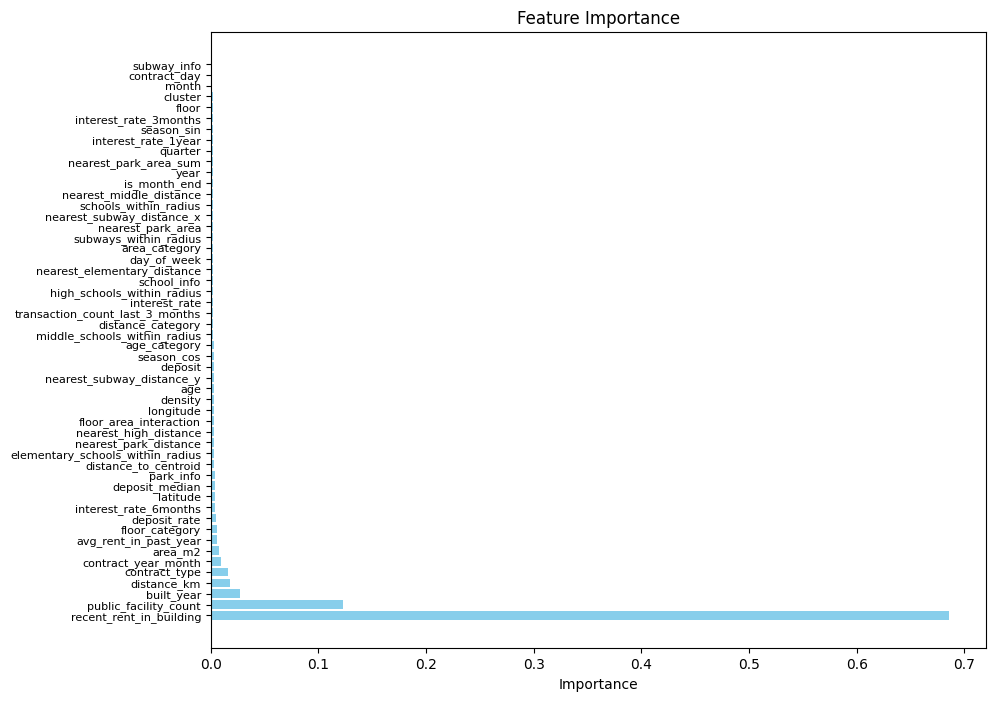

In [11]:
importance = model.spatial_model.feature_importances_
# Feature importance를 DataFrame으로 변환
train_df = train_data_scaled.copy()

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Feature Importance')
plt.show()

In [12]:
#### 상위 20개에 대한 데이터만 실험
top_20_features = list(importance_df.head(20)['Feature'].values)
top_20_features

['recent_rent_in_building',
 'public_facility_count',
 'built_year',
 'distance_km',
 'contract_type',
 'contract_year_month',
 'area_m2',
 'avg_rent_in_past_year',
 'floor_category',
 'deposit_rate',
 'interest_rate_6months',
 'latitude',
 'deposit_median',
 'park_info',
 'distance_to_centroid',
 'elementary_schools_within_radius',
 'nearest_park_distance',
 'nearest_high_distance',
 'floor_area_interaction',
 'longitude']

In [13]:
total_train_data = pd.concat([train_data, valid_data])

df_total_new = total_train_data.copy()
df_test_new = test_data.copy()

df_total_new_sorted = df_total_new.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'date'])

df_total_new_sorted['recent_rent_in_building'] = df_total_new_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].shift(1)
df_total_new_sorted['recent_rent_in_building'].fillna(df_total_new_sorted['deposit'], inplace=True)

# 마지막 계약가 계산
recent_rent_df_map = df_total_new_sorted[['latitude', 'longitude', 'built_year', 'area_m2', 'recent_rent_in_building']].reset_index()
recent_rent_df_map_index = recent_rent_df_map.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].nth(-1).index
recent_rent_df_map_scaled = recent_rent_df_map.loc[recent_rent_df_map_index]

df_test_new = df_test_new.merge(recent_rent_df_map_scaled[['latitude', 'longitude', 'built_year', 'area_m2', 'recent_rent_in_building']], 
                                    on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')

df_test_new['recent_rent_in_building'].fillna(recent_rent_df_map['recent_rent_in_building'].median(), inplace=True)

total_train_data_dep = df_total_new_sorted.sort_index()
test_data_dep = df_test_new

In [14]:
# total_train_data = pd.concat([train_data, valid_data])

## deposit feature
print("create deposit feature 1")
# total_train_data_dep, test_data_dep = add_recent_rent_in_building(total_train_data, test_data, type = 'test')
# print(total_train_data_dep.shape,test_data_dep.shape)
print("create deposit feature 2")
total_train_data_dep, test_data_dep = add_avg_rent_in_past_year(total_train_data_dep, test_data_dep, type = 'test')
print(test_data_dep.shape)
print("create deposit feature 3")
total_train_data_dep, test_data_dep = add_rent_growth_rate(total_train_data_dep, test_data_dep, type = 'test')
print(test_data_dep.shape)

create deposit feature 1
create deposit feature 2
(150172, 54)
create deposit feature 3
(150172, 55)


In [15]:
feat = top_20_features + ['deposit']

total_train_data_dep = total_train_data_dep[feat]
test_data_dep = test_data_dep[feat]

In [16]:
### 정규화
print("standardization...")

exclude_cols = ['deposit']

# 스케일링할 수치형 변수 선택
features_to_scale = [col for col in total_train_data_dep.columns 
                    if col not in exclude_cols and total_train_data_dep[col].dtype in ['int64', 'float64']]

scaler = StandardScaler()

total_train_data_scaled = total_train_data_dep.copy()
total_train_data_scaled[features_to_scale] = scaler.fit_transform(total_train_data_dep[features_to_scale])

test_data_scaled = test_data_dep.copy()
test_data_scaled[features_to_scale] = scaler.transform(test_data_dep[features_to_scale])

# feature selection
# train_data, valid_data, test_data = preprocessing.feature_selection(train_data, valid_data, test_data)

standardization...


In [17]:
 # train with total dataset
print("Training with total dataset...")

spatial_weight_matrix.generate_weight_matrices(total_train_data_scaled, total_train_data_scaled, dataset_type='train_total')
spatial_weight_matrix.generate_weight_matrices(test_data_scaled, total_train_data_scaled, dataset_type='test')

model = XGBoostWithSpatialWeight(spatial_weight_matrix)
model.train(total_train_data_scaled, dataset_type='train_total')

Training with total dataset...


In [18]:
sample_submission = Directory.sample_submission
sample_submission['deposit'] = model.inference(test_data_scaled, total_train_data_scaled)
# save sample submission
# save sample submission
submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/result", "submission")
os.makedirs(submission_path, exist_ok=True)

submission_file_path = os.path.join(submission_path, 'plus deposit features and feature20+weighted matrix xgboost')
sample_submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

print("Successfully executed main.py.")

Successfully executed main.py.
